# Training neural network force fields (NNFFs) with AMPtorch


Edited by N. Hu

Medford Research Group at Georgia Tech

08/25/2021

This ipython notebook of training NNFFs is based on the BDQM-VIP lecture materials and the sample scripts provided by AMPtorch (`amptorch/example/`) for both conventional Symmetry Functions as finger-printing scheme + Behler-Parrnello atomistic neural network structure (2nd Generation NN), and Gaussian Multi-Pole + SingleNN neural network structure.

This paper introduces the basics and the formulation of Gaussian Multi-pole (GMP) descriptors: 
<https://arxiv.org/abs/2102.02390?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%253A+arxiv%252FQSXk+%2528ExcitingAds%2521+cs+updates+on+arXiv.org%2529>


# Table of contents
1. [Training with Symmetry Function and BPNN](#training_bp)
2. [Training with GMP and SingleNN](#training_gmp)

## Training on CuCO with Symmetry Functions + 2nd Gen NNFF <a name="training_bp"></a>

### Construct the training dataset

As an example, we calculate the potential energy and forces for CuCO chemical system with the EMT calculator implemented in ase. 

This step should be replaced with training datasets that have information on:
1. cell size
2. periodic boundary conditions
3. atomic positions
4. potential energy
5. forces, if doing force training

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from ase import Atoms
import ase.io
from ase.calculators.emt import EMT
from ase.build import molecule


from amptorch.ase_utils import AMPtorch
from amptorch.trainer import AtomsTrainer

In [2]:
# get training images

distances = np.linspace(2, 5, 100)
images = []
for dist in distances:
    image = Atoms(
        "CuCO",
        [
            (-dist * np.sin(0.65), dist * np.cos(0.65), 0),
            (0, 0, 0),
            (dist * np.sin(0.65), dist * np.cos(0.65), 0),
        ],
    )
    image.set_cell([10, 10, 10])
    image.wrap(pbc=True)
    image.set_calculator(EMT())
    images.append(image)

### Define fingerprinting scheme

Here we demonstrate with the conventional Symmetry functions, $G^2$ and $G^4$. 

In [3]:
# define parameters for finger-printing scheme, Symmetry Function

Gs = {
    "default": {
        "G2": {
            "etas": np.logspace(np.log10(0.05), np.log10(5.0), num=4),
            "rs_s": [0],
        },
        "G4": {"etas": [0.005], "zetas": [1.0, 4.0], "gammas": [1.0, -1.0]},
        "cutoff": 6,
    },
}

### Define the configuration for trainer object

Detailed introductions and other specifications supported in trainer object can be found here under Section Usage/Configs: 
<https://github.com/ulissigroup/amptorch/tree/MCSH_paper1_lmdb>

In [4]:
config = {
    "model": {
        "get_forces": True,
        "num_layers": 3,
        "num_nodes": 5,
        "batchnorm": True,
    },
    "optim": {
        "force_coefficient": 0.04,
        "lr": 1e-3,
        "batch_size": 32,
        "epochs": 10,
        "loss": "mse",
        "metric": "mae",
        "gpus": 0,
    },
    "dataset": {
        "raw_data": images,
        "fp_params": Gs,
        "save_fps": True,
        "scaling": {"type": "normalize", "range": (0, 1)},
        "val_split": 0,
    },
    "cmd": {
        "debug": False,
        "run_dir": "./",
        "seed": 1,
        "identifier": "test",
        "verbose": True,
        # Weights and Biases used for logging - an account(free) is required
        "logger": False,
    },
}

### Hit go and train

In [5]:
torch.set_num_threads(1)
trainer = AtomsTrainer(config)
trainer.train()

Results saved to ./checkpoints/2021-08-25-16-01-49-test



Loading dataset: 100 images
Loading model: 1023 parameters
Loading skorch trainer
  epoch    train_energy_mae    train_forces_mae    train_loss    cp     dur
-------  ------------------  ------------------  ------------  ----  ------
      1              0.6699              0.3765        0.4504     +  0.0512
      2              0.5186              0.3440        0.4043     +  0.0392
      3              0.4314              0.3344        0.3154     +  0.0378
      4              0.4169              0.3338        0.3565     +  0.0496


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


      5              0.3966              0.3392        0.2084     +  0.0381
      6              0.3887              0.3378        0.4124     +  0.0393
      7              0.3740              0.3360        0.1773     +  0.0379
      8              0.3564              0.3336        0.2445     +  0.0496
      9              0.3358              0.3375        0.1515     +  0.0495
     10              0.2942              0.3359        0.2218     +  0.0380
Training completed in 0.5143406391143799s


0.5143406391143799

### Use the neural network as an ase calculator to make predictions

In [6]:
predictions = trainer.predict(images)

# assess errors

true_energies = np.array([image.get_potential_energy() for image in images])
pred_energies = np.array(predictions["energy"])

print("Energy MSE:", np.mean((true_energies - pred_energies) ** 2))
print("Energy MAE:", np.mean(np.abs(true_energies - pred_energies)))

images[0].set_calculator(AMPtorch(trainer))
images[0].get_potential_energy()

Energy MSE: 0.41248591114113947
Energy MAE: 0.3939685106821985


10.50893783569336

## Training on 2D water dataset with GMP + SingleNN <a name="training_gmp"></a>

### Construct the training dataset

As an example of the training dataset, we calculate the potential energy and forces for 2-D single water potential energy surface. This dataset is calculated by Quantem Espresso (xc, PBE. kpts, (1,1,1). Planewave, 500.) One O-H bond length is fixed, and the other O-H length and the H-O-H bond angle are allowed to vary. 

Required information in the training datasets contains:
1. cell size
2. periodic boundary conditions
3. atomic positions
4. potential energy
5. forces, if doing force training

In [7]:
# get training images by reading trajectory files

# read all images from the trajectory
# training = ase.io.read("./data/single_water_2D.traj", index=":")

# read every 10th image from the trajectory
training = ase.io.read("./data/single_water_2D.traj", index="::10")

# print the length of the image
len(training)

101

In [8]:
# check the information

# cell size
print(training[0].get_cell())

# periodic boundary condition
print(training[0].get_pbc())

# atomic positions
print(training[0].get_positions())

# system potential energy
print(training[0].get_potential_energy())

# forces
print(training[0].get_forces())

# ase.Atoms object
print(training[0])

Cell([10.0, 10.0, 10.0])
[ True  True  True]
[[5.         5.         5.2981545 ]
 [5.         5.763239   4.7018455 ]
 [5.87240588 3.09291855 4.26505605]]
-593.3815601078402
[[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-0.6816002   1.67015579  0.67090199]]
Atoms(symbols='OH2', pbc=True, cell=[10.0, 10.0, 10.0], momenta=..., constraint=FixAtoms(indices=[0, 1]), calculator=SinglePointCalculator(...))


### Define fingerprinting scheme

Here we demonstrate with the GMP fingerprinting scheme. It requires the fitted pseduo-potentials of every elements. Access to the fitted pseduo-potentials:
<https://github.com/ulissigroup/amptorch/tree/MCSH_paper1_lmdb/examples/GMP/valence_gaussians>

Like G2 and G4 symmetry functions, GMP uses $\sigma$'s in the radial coordinates and MCSH groups and orders in the angular coordinates.

In [9]:
sigmas = [0.2, 0.69, 1.1, 1.66, 2.66]

MCSHs = {
    "MCSHs": {
        "0": {"groups": [1], "sigmas": sigmas},
        "1": {"groups": [1], "sigmas": sigmas},
        "2": {"groups": [1, 2], "sigmas": sigmas},
        "3": {"groups": [1, 2, 3], "sigmas": sigmas},
        # "4": {"groups": [1, 2, 3, 4], "sigmas": sigmas},
        # "5": {"groups": [1, 2, 3, 4, 5], "sigmas": sigmas},
        # "6": {"groups": [1, 2, 3, 4, 5, 6, 7], "sigmas": sigmas},
    },
    "atom_gaussians": {
        "H": "./valence_gaussians/H_pseudodensity_2.g",
        "O": "./valence_gaussians/O_pseudodensity_4.g",
    },
    "cutoff": 8,
}

elements = ["H", "O"]

### Define the configuration for trainer object

Detailed introductions and other specifications supported in trainer object can be found here under Section Usage/Configs: 
<https://github.com/ulissigroup/amptorch/tree/MCSH_paper1_lmdb>

In [10]:
config = {
    "model": {
        "name":"singlenn",
        "get_forces": True,
        "num_layers": 3,
        "num_nodes": 5,
        "batchnorm": True,
    },
    "optim": {
        "force_coefficient": 0.04,
        "lr": 1e-3,
        "batch_size": 8,
        "epochs": 100,
        "loss": "mse",
        "metric": "mae",
    },
    "dataset": {
        "raw_data": training,
        "fp_scheme": "gmp",
        "fp_params": MCSHs,
        "elements": elements,
        "save_fps": True,
        "scaling": {"type": "normalize", "range": (0, 1)},
        "val_split": 0,
    },
    "cmd": {
        "debug": False,
        "run_dir": "./",
        "seed": 1,
        "identifier": "test",
        "verbose": True,
        # Weights and Biases used for logging - an account(free) is required
        "logger": False,
    },
}

### Hit go and train

In [11]:
torch.set_num_threads(1)
trainer = AtomsTrainer(config)
trainer.train()

Results saved to ./checkpoints/2021-08-25-16-01-53-test



Loading dataset: 101 images
Loading model: 236 parameters
Loading skorch trainer
  epoch    train_energy_mae    train_forces_mae    train_loss    cp     dur
-------  ------------------  ------------------  ------------  ----  ------
      1              1.0118              1.1103        0.9195     +  0.0603
      2              0.8604              0.8896        0.6673     +  0.0581
      3              0.7323              0.7510        0.4950     +  0.0576
      4              0.6032              0.8569        0.3794     +  0.0582
      5              0.5157              0.7930        0.3109     +  0.0577
      6              0.4258              0.8564        0.2509     +  0.0584
      7              0.3952              0.8701        0.2507     +  0.0581
      8              0.3417              0.8318        0.1919     +  0.0576
      9              0.3032              0.9061        0.1791     +  0.0582
     10              0.3350              0.8214        0.1963        0.0585
     1

     95              0.0975              0.3275        0.0193     +  0.0588
     96              0.1000              0.3486        0.0280        0.0582
     97              0.1105              0.3660        0.0230        0.0576
     98              0.1067              0.3404        0.0299        0.0585
     99              0.1039              0.3376        0.0191        0.0586
    100              0.1149              0.3589        0.0286        0.0569
Training completed in 6.6894073486328125s


6.6894073486328125

### Use the neural network as an ase calculator to make predictions

In [12]:
predictions = trainer.predict(training)

# assess errors

true_energies = np.array([image.get_potential_energy() for image in training])
pred_energies = np.array(predictions["energy"])

print("Energy MSE:", np.mean((true_energies - pred_energies) ** 2))
print("Energy MAE:", np.mean(np.abs(true_energies - pred_energies)))

training[0].set_calculator(AMPtorch(trainer))
training[0].get_potential_energy()

Energy MSE: 0.00715544224881187
Energy MAE: 0.06294999506214351


-593.8175048828125

### Use the fitted model to predict the 1D PES for change in O-H bond length

In [13]:
# set up images with one changing bond length
distances = np.linspace(0.8, 1.2, 100)
images = []
for dist in distances:
    image = molecule("H2O", vacuum=10.0)
    image.set_cell([10, 10, 10])
    image.set_pbc([1, 1, 1])

    # change bond length
    image.set_distance(0, 2, dist)
    images.append(image)

predictions = trainer.predict(images)

Text(0, 0.5, 'potential energy [eV]')

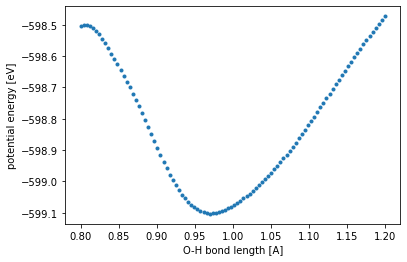

In [14]:
plt.plot(distances, predictions["energy"], ".")
plt.xlabel("O-H bond length [A]")
plt.ylabel("potential energy [eV]")